# Libraries & Custom functions

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from tqdm import tqdm

# Ignore UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
############################################################### Functions for Part 1 b) ###############################################################


def BCE_Loss(y_true, y_hat):
    if y_true == y_hat:
        return torch.tensor(0.)
    
    return -1 * (y_true * torch.log(y_hat) + (1 - y_true) * torch.log(1 - y_hat))


def ForwardPass(X, W, b = 0):

    z1 = torch.matmul(X, W[0].T) + b
    a1 = F.relu(z1)

    z2 = torch.matmul(a1, W[1].T) + b
    a2 = F.leaky_relu(z2, negative_slope = 0.01)

    z3 = torch.matmul(a2, W[2].T) + b
    a3 = F.sigmoid(z3)

    return a3, a2, a1


def BackwardPass(X, a1, a2, a3, y_true, W):

    # Partial derivative of the loss function with respect to the prediction
    dL_da3 = -1 * (y_true / a3 - (1 - y_true) / (1 - a3)) if y_true != a3 else torch.tensor([0.])
    # Partial derivative of the loss function with respect to z3, using the sigmoid derivative
    dL_dz3 = dL_da3 * (a3 * (1 - a3))
    # Partial derivative of the loss function with respect to the weights of the connections between the second hidden layer and the output layer
    dL_dW3 = torch.matmul(dL_dz3.T, a2)

    # Partial derivative of the loss function with respect to the activation values from the second hidden layer
    dL_da2 = torch.matmul(dL_dz3, W[2])
    # Partial derivative of the loss function with respect to z2, using the Leaky ReLU derivative
    dL_dz2 = torch.where(a2 >= 0, dL_da2, 0.01 * dL_da2)
    # Partial derivative of the loss function with respect to the weights of the connections between the first and second hidden layers
    dL_dW2 = torch.matmul(dL_dz2.T, a1)

    # Partial derivative of the loss function with respect to the activation values from the first hidden layer
    dL_da1 = torch.matmul(dL_dz2, W[1])
    # Partial derivative of the loss function with respect to z2, using the ReLU derivative
    dL_dz1 = torch.where(a1 >= 0, dL_da1, 0.0 * dL_da1)
    # Partial derivative of the loss function with respect to the weights of the connections between the input layer and the first hidden layers
    dL_dW1 = torch.matmul(dL_dz1.T, X)

    return dL_dW1, dL_dW2, dL_dW3


def StochasticGradientDescent(dL_dW1, dL_dW2, dL_dW3, W, lr):
    # Update weights using SGD
    W[0] -= lr * dL_dW1
    W[1] -= lr * dL_dW2
    W[2] -= lr * dL_dW3

    return W


############################################################### Functions for Part 1 c) and d) ###############################################################


def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        
    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


class NeuralNetwork_Exercise1_c(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 256)  # Input size for MNIST is 28x28=784
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 10)   # 10 output classes for Fashion-MNIST

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Define a more complex neural network
class NeuralNetwork_Exercise1_d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = torch.nn.Linear(784, 256)
        self.fc_256_512 = torch.nn.Linear(256, 512)
        self.fc_512_1024 = torch.nn.Linear(512, 1024)
        self.fc_1024_2048 = torch.nn.Linear(1024, 2048)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(256, 128)
        self.output_layer = torch.nn.Linear(128, 10)
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.batch_norm256(self.input_layer(x)))
        x = self.relu(self.batch_norm512(self.fc_256_512(x)))
        x = self.dropout_10(x)
        x = self.relu(self.batch_norm1024(self.fc_512_1024(x)))
        x = self.dropout_20(x)
        x = self.relu(self.batch_norm2048(self.fc_1024_2048(x)))
        x = self.dropout_30(x)
        x = self.relu(self.batch_norm1024(self.fc_2048_1024(x)))
        x = self.dropout_30(x)
        x = self.relu(self.batch_norm512(self.fc_1024_512(x)))
        x = self.dropout_20(x)
        x = self.relu(self.batch_norm256(self.fc_512_256(x)))
        x = self.dropout_10(x)
        x = self.relu(self.batch_norm128(self.fc_256_128(x)))
        x = self.dropout_10(x)
        x = self.output_layer(x)
        return x


def train(model, train_loader, optimizer, loss_func, epochs, device, **kwargs):

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('Training phase...')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total = len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}%')

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print()
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist


def test(model, test_loader, loss_func, device):

    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels).item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    print(f"Cross-Entropy on test set: {test_loss:.4f}")
    print(f"Accuracy on test set: {test_acc:.2f}%")

    return test_loss, test_acc

# Exercise 1

## Exercise 1, a)

To optimize deep neural networks (DNN) backpropagation and gradient descent are often used.
Distinguish between these two algorithms, if there is any distinction, and explain how they can be
used for DNN optimization.


**Backpropagation vs. Gradient Descent for DNN Optimization**

**Distinction**

Backpropagation is an algorithm for calculating the gradient of a loss function with respect to the parameters of a neural network. Gradient descent is an algorithm for optimizing a function by iteratively moving in the direction of the negative gradient.

How they can be used for DNN optimization

Backpropagation is used to calculate the gradient of the loss function with respect to the weights of the neural network. This gradient is then used by gradient descent to update the weights in the direction of the negative gradient, which reduces the loss function.

**Example**

Consider a simple neural network with two inputs, one hidden layer, and one output. The loss function for this network could be the mean squared error between the predicted output and the ground truth output.

To use backpropagation to calculate the gradient of the loss function with respect to the weights of the network, we would start at the output layer and work our way backwards. At each layer, we would calculate the error at that layer and then propagate it back to the previous layer. This process would continue until we reached the input layer.

Once we have calculated the gradient of the loss function with respect to the weights of the network, we can use gradient descent to update the weights in the direction of the negative gradient. This will help the network to learn and reduce the loss function.

Advantages and disadvantages

**Backpropagation**

Advantages:
Easy to implement
Efficient for calculating the gradient of the loss function with respect to the weights of a neural network
Disadvantages:
Can be computationally expensive for large neural networks

**Gradient descent**

Advantages:
Simple to implement
Efficient for optimizing a function by iteratively moving in the direction of the negative gradient
Disadvantages:
Can be prone to getting stuck in local minima
Conclusion

Backpropagation and gradient descent are two essential algorithms for optimizing deep neural networks. Backpropagation is used to calculate the gradient of the loss function with respect to the weights of the network, while gradient descent is used to update the weights in the direction of the negative gradient. By combining these two algorithms, we can train deep neural networks to perform complex tasks.

#### References

 - https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/#:~:text=To%20put%20it%20plainly%2C%20gradient,gradient%20descent%20relies%20on%20backpropagation.

## Exercise 1, b)

In [3]:
input_values = torch.tensor([[5., 4., 1., 3., 2.]])

y_true = torch.tensor([1.])

w1 = torch.tensor([[0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2, 0.2, 0.2]])

w2 = torch.tensor([[0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2]])

w3 = torch.tensor([[0.2, 0.2]])

W = list([w1, w2, w3])

In [4]:
a3, a2, a1 = ForwardPass(input_values, W)
loss = BCE_Loss(y_true, a3)

print("Predicted Output (a3):", a3.item())
print("Expected Output (y_true):", y_true.item())
print("Binary Cross-Entropy Loss:", loss.item())

Predicted Output (a3): 0.6726070046424866
Expected Output (y_true): 1.0
Binary Cross-Entropy Loss: 0.3965940773487091


In [5]:
dL_dW1, dL_dW2, dL_dW3 = BackwardPass(input_values, a1, a2, a3, y_true, W)

print("dL_dW1:", dL_dW1)
print("dL_dW2:", dL_dW2)
print("dL_dW3:", dL_dW3)

dL_dW1: tensor([[-0.1310, -0.1048, -0.0262, -0.0786, -0.0524],
        [-0.1310, -0.1048, -0.0262, -0.0786, -0.0524],
        [-0.1310, -0.1048, -0.0262, -0.0786, -0.0524]])
dL_dW2: tensor([[-0.1964, -0.1964, -0.1964],
        [-0.1964, -0.1964, -0.1964]])
dL_dW3: tensor([[-0.5893, -0.5893]])


In [6]:
W = StochasticGradientDescent(dL_dW1, dL_dW2, dL_dW3, W, lr = 0.2)

print("Updated W1:", W[0])
print("Updated W2:", W[1])
print("Updated W3:", W[2])

Updated W1: tensor([[0.2262, 0.2210, 0.2052, 0.2157, 0.2105],
        [0.2262, 0.2210, 0.2052, 0.2157, 0.2105],
        [0.2262, 0.2210, 0.2052, 0.2157, 0.2105]])
Updated W2: tensor([[0.2393, 0.2393, 0.2393],
        [0.2393, 0.2393, 0.2393]])
Updated W3: tensor([[0.3179, 0.3179]])


<h2>After updating your weights what do you observe? Explain why.</h2>
<p>After computing the loss and doing a backward pass, and given that all weights were initialized with the value 2, we can see that none of the weights changed. Tracing back the steps made, we can see that all partial derivatives with respect to all the weights have a value of 0, which corroborates the fact that none of the weight's values changed. These partial derivatives measure the weight's variation in order for the loss of the neural network to decrease. So, the question now becomes, why all partial derivatives with respect to all weights show that no variation in their values is required in order to decrease the loss? Well, that's because the loss is already at its minimum, which is zero. Looking at how the binary loss is computed, we see that both the expected value and predicted value are exactly the same value, one, meaning that our network predicted perfectly the target. So, this means that there's no more room for improvement, and that's why all partial derivatives with respect to the weights are zero, and as consequence, the weight matrices didn't change.</p>

#### References

https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c

## Exercise 1, c)

### Visualization

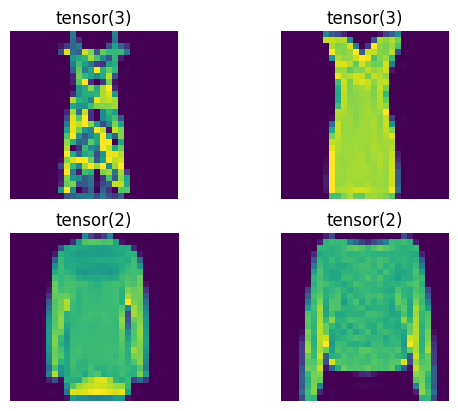

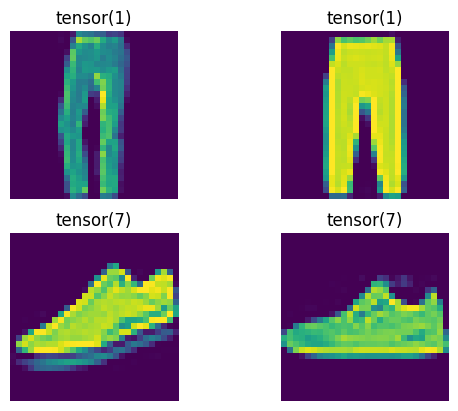

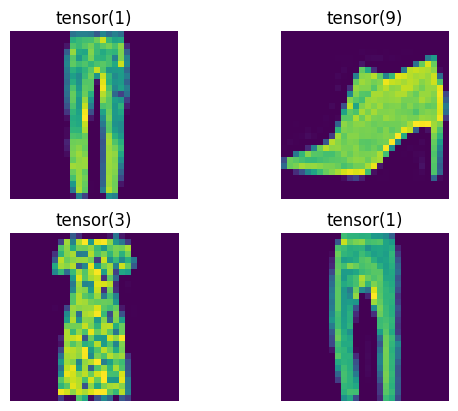

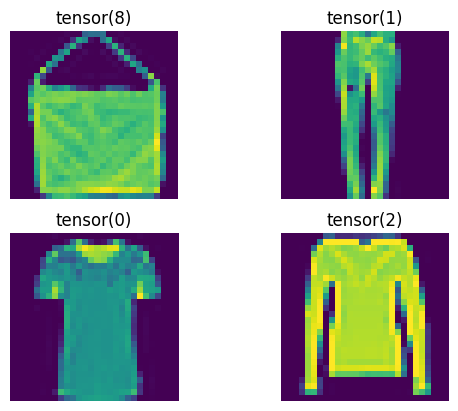

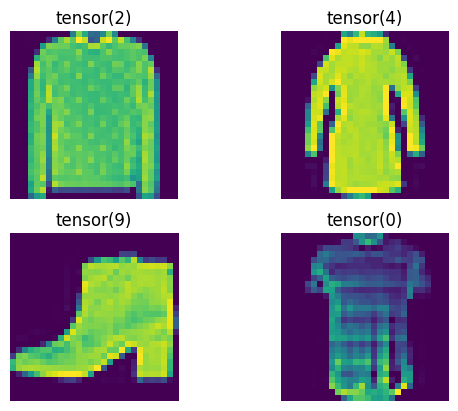

In [16]:
import matplotlib.pyplot as plt

for i, (images, labels) in enumerate(train_loader):
    if i == 5:
        break
    for j in range(4):
        plt.subplot(2, 2, j + 1)
        plt.imshow(images[j].numpy().transpose((1, 2, 0)))
        plt.title(str(labels[j]))
        plt.axis('off')
    plt.show()


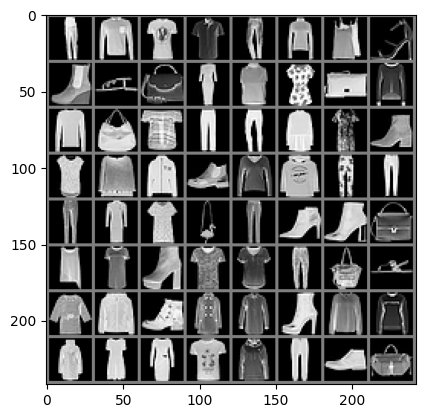

    1     2     0     6     1     2     0     5     9     5     8     3     0     3     8     2     2     8     6     1     1     3     3     9     6     0     4     9     2     2     1     1     1     3     3     8     1     9     9     8     6     3     9     0     0     1     8     5     3     4     9     4     6     9     6     2     4     3     3     0     2     1     9     8


In [15]:
# Define a function to display a batch of images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Fix the missing closing parenthesis
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{labels[j]:5}' for j in range(batch_size)))




### Training Loop

In [7]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.FashionMNIST(root = './data', train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)

TrainLoader = torch.utils.data.DataLoader(trainset, batch_size = 256, shuffle = True)
TestLoader = torch.utils.data.DataLoader(testset, batch_size = 256, shuffle = False)

In [8]:
# Initialize the network, loss function, and optimizer
device = set_device()
NeuralNetwork = NeuralNetwork_Exercise1_c().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr = 0.01)

Device: mps


In [9]:
train_loss_hist, train_acc_hist = train(NeuralNetwork, TrainLoader, optimizer, criterion, epochs = 32, device = device)

Epoch 1/32
Training phase...


  0%|          | 0/235 [00:00<?, ?it/s]

Loss = 0.4491  |  Accuracy = 79.82%: 100%|██████████| 235/235 [00:03<00:00, 64.07it/s]


Training Cross-Entropy Loss = 0.5624
Training Accuracy = 79.82%

Epoch 2/32
Training phase...


Loss = 0.4286  |  Accuracy = 85.95%: 100%|██████████| 235/235 [00:03<00:00, 66.03it/s]


Training Cross-Entropy Loss = 0.3841
Training Accuracy = 85.95%

Epoch 3/32
Training phase...


Loss = 0.3428  |  Accuracy = 87.21%: 100%|██████████| 235/235 [00:03<00:00, 67.75it/s]


Training Cross-Entropy Loss = 0.3500
Training Accuracy = 87.21%

Epoch 4/32
Training phase...


Loss = 0.4438  |  Accuracy = 87.90%: 100%|██████████| 235/235 [00:03<00:00, 73.34it/s]


Training Cross-Entropy Loss = 0.3299
Training Accuracy = 87.90%

Epoch 5/32
Training phase...


Loss = 0.3645  |  Accuracy = 88.28%: 100%|██████████| 235/235 [00:03<00:00, 74.87it/s]


Training Cross-Entropy Loss = 0.3160
Training Accuracy = 88.28%

Epoch 6/32
Training phase...


Loss = 0.3118  |  Accuracy = 88.88%: 100%|██████████| 235/235 [00:03<00:00, 75.11it/s]


Training Cross-Entropy Loss = 0.3016
Training Accuracy = 88.88%

Epoch 7/32
Training phase...


Loss = 0.3814  |  Accuracy = 89.17%: 100%|██████████| 235/235 [00:03<00:00, 73.35it/s]


Training Cross-Entropy Loss = 0.2911
Training Accuracy = 89.17%

Epoch 8/32
Training phase...


Loss = 0.2901  |  Accuracy = 89.19%: 100%|██████████| 235/235 [00:03<00:00, 70.83it/s]


Training Cross-Entropy Loss = 0.2913
Training Accuracy = 89.19%

Epoch 9/32
Training phase...


Loss = 0.4276  |  Accuracy = 89.54%: 100%|██████████| 235/235 [00:03<00:00, 72.08it/s]


Training Cross-Entropy Loss = 0.2833
Training Accuracy = 89.54%

Epoch 10/32
Training phase...


Loss = 0.2152  |  Accuracy = 89.80%: 100%|██████████| 235/235 [00:03<00:00, 74.90it/s]


Training Cross-Entropy Loss = 0.2751
Training Accuracy = 89.80%

Epoch 11/32
Training phase...


Loss = 0.2422  |  Accuracy = 89.72%: 100%|██████████| 235/235 [00:03<00:00, 69.46it/s]


Training Cross-Entropy Loss = 0.2752
Training Accuracy = 89.72%

Epoch 12/32
Training phase...


Loss = 0.1982  |  Accuracy = 90.11%: 100%|██████████| 235/235 [00:03<00:00, 66.35it/s]


Training Cross-Entropy Loss = 0.2628
Training Accuracy = 90.11%

Epoch 13/32
Training phase...


Loss = 0.2203  |  Accuracy = 89.92%: 100%|██████████| 235/235 [00:03<00:00, 71.03it/s]


Training Cross-Entropy Loss = 0.2703
Training Accuracy = 89.92%

Epoch 14/32
Training phase...


Loss = 0.2160  |  Accuracy = 89.89%: 100%|██████████| 235/235 [00:03<00:00, 69.04it/s]


Training Cross-Entropy Loss = 0.2705
Training Accuracy = 89.89%

Epoch 15/32
Training phase...


Loss = 0.2123  |  Accuracy = 90.34%: 100%|██████████| 235/235 [00:03<00:00, 69.38it/s]


Training Cross-Entropy Loss = 0.2569
Training Accuracy = 90.34%

Epoch 16/32
Training phase...


Loss = 0.1671  |  Accuracy = 90.67%: 100%|██████████| 235/235 [00:03<00:00, 70.93it/s]


Training Cross-Entropy Loss = 0.2511
Training Accuracy = 90.67%

Epoch 17/32
Training phase...


Loss = 0.1909  |  Accuracy = 90.49%: 100%|██████████| 235/235 [00:03<00:00, 70.11it/s]


Training Cross-Entropy Loss = 0.2533
Training Accuracy = 90.49%

Epoch 18/32
Training phase...


Loss = 0.2681  |  Accuracy = 90.69%: 100%|██████████| 235/235 [00:03<00:00, 70.40it/s]


Training Cross-Entropy Loss = 0.2498
Training Accuracy = 90.69%

Epoch 19/32
Training phase...


Loss = 0.2499  |  Accuracy = 90.75%: 100%|██████████| 235/235 [00:03<00:00, 73.61it/s]


Training Cross-Entropy Loss = 0.2439
Training Accuracy = 90.75%

Epoch 20/32
Training phase...


Loss = 0.3180  |  Accuracy = 90.93%: 100%|██████████| 235/235 [00:03<00:00, 72.33it/s]


Training Cross-Entropy Loss = 0.2444
Training Accuracy = 90.93%

Epoch 21/32
Training phase...


Loss = 0.2833  |  Accuracy = 90.87%: 100%|██████████| 235/235 [00:03<00:00, 73.92it/s]


Training Cross-Entropy Loss = 0.2441
Training Accuracy = 90.87%

Epoch 22/32
Training phase...


Loss = 0.2619  |  Accuracy = 91.06%: 100%|██████████| 235/235 [00:03<00:00, 68.25it/s]


Training Cross-Entropy Loss = 0.2388
Training Accuracy = 91.06%

Epoch 23/32
Training phase...


Loss = 0.3351  |  Accuracy = 91.24%: 100%|██████████| 235/235 [00:03<00:00, 71.71it/s]


Training Cross-Entropy Loss = 0.2320
Training Accuracy = 91.24%

Epoch 24/32
Training phase...


Loss = 0.2545  |  Accuracy = 91.25%: 100%|██████████| 235/235 [00:03<00:00, 69.50it/s]


Training Cross-Entropy Loss = 0.2371
Training Accuracy = 91.25%

Epoch 25/32
Training phase...


Loss = 0.4227  |  Accuracy = 91.32%: 100%|██████████| 235/235 [00:03<00:00, 70.46it/s]


Training Cross-Entropy Loss = 0.2338
Training Accuracy = 91.32%

Epoch 26/32
Training phase...


Loss = 0.1817  |  Accuracy = 91.49%: 100%|██████████| 235/235 [00:03<00:00, 70.92it/s]


Training Cross-Entropy Loss = 0.2277
Training Accuracy = 91.49%

Epoch 27/32
Training phase...


Loss = 0.1537  |  Accuracy = 91.28%: 100%|██████████| 235/235 [00:03<00:00, 71.22it/s]


Training Cross-Entropy Loss = 0.2389
Training Accuracy = 91.28%

Epoch 28/32
Training phase...


Loss = 0.2628  |  Accuracy = 91.47%: 100%|██████████| 235/235 [00:03<00:00, 70.70it/s]


Training Cross-Entropy Loss = 0.2296
Training Accuracy = 91.47%

Epoch 29/32
Training phase...


Loss = 0.1778  |  Accuracy = 91.56%: 100%|██████████| 235/235 [00:03<00:00, 71.95it/s]


Training Cross-Entropy Loss = 0.2260
Training Accuracy = 91.56%

Epoch 30/32
Training phase...


Loss = 0.2306  |  Accuracy = 91.73%: 100%|██████████| 235/235 [00:03<00:00, 71.89it/s]


Training Cross-Entropy Loss = 0.2199
Training Accuracy = 91.73%

Epoch 31/32
Training phase...


Loss = 0.3974  |  Accuracy = 91.95%: 100%|██████████| 235/235 [00:03<00:00, 71.66it/s]


Training Cross-Entropy Loss = 0.2129
Training Accuracy = 91.95%

Epoch 32/32
Training phase...


Loss = 0.1505  |  Accuracy = 91.91%: 100%|██████████| 235/235 [00:03<00:00, 71.47it/s]

Training Cross-Entropy Loss = 0.2147
Training Accuracy = 91.91%

Cross-Entropy on training set:  0.2147
Accuracy on training set:       91.91%


In [10]:
test_loss, test_acc = test(NeuralNetwork, TestLoader, criterion, device)

Cross-Entropy on test set: 0.4401
Accuracy on test set: 87.39%


## Exercise 1, d) 

To improve the previous feedforward neural network for the Fashion-MNIST classification task, we can make the following changes:

**Increase Network Complexity**: We can add more hidden layers and neurons to increase the network's capacity to learn complex patterns in the data.

**Use Different Activation Function**: Instead of using ReLU (Rectified Linear Unit) activation, we can try a different activation function like Leaky ReLU, which might help with training.

**Regularization Techniques**: To prevent overfitting, we can add dropout layers and L2 regularization to the network.

**Batch Normalization**: Applying batch normalization can help stabilize and speed up training.

In [16]:
# Initialize the network, loss function, and optimizer
device = set_device()
NeuralNetwork_complex = NeuralNetwork_Exercise1_d().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNetwork_complex.parameters(), lr = 0.01, weight_decay = 1e-5)  # L2 regularization

Device: mps


In [17]:
train_loss_hist, train_acc_hist = train(NeuralNetwork_complex, TrainLoader, optimizer, criterion, epochs = 64, device = device)

Epoch 1/64
Training phase...


Loss = 0.5707  |  Accuracy = 79.23%: 100%|██████████| 235/235 [00:08<00:00, 26.50it/s]


Training Cross-Entropy Loss = 0.5753
Training Accuracy = 79.23%

Epoch 2/64
Training phase...


Loss = 0.5349  |  Accuracy = 85.31%: 100%|██████████| 235/235 [00:08<00:00, 26.88it/s]


Training Cross-Entropy Loss = 0.4201
Training Accuracy = 85.31%

Epoch 3/64
Training phase...


Loss = 0.4972  |  Accuracy = 86.58%: 100%|██████████| 235/235 [00:08<00:00, 27.12it/s]


Training Cross-Entropy Loss = 0.3850
Training Accuracy = 86.58%

Epoch 4/64
Training phase...


Loss = 0.2332  |  Accuracy = 87.51%: 100%|██████████| 235/235 [00:08<00:00, 27.34it/s]


Training Cross-Entropy Loss = 0.3589
Training Accuracy = 87.51%

Epoch 5/64
Training phase...


Loss = 0.2574  |  Accuracy = 87.86%: 100%|██████████| 235/235 [00:08<00:00, 27.22it/s]


Training Cross-Entropy Loss = 0.3447
Training Accuracy = 87.86%

Epoch 6/64
Training phase...


Loss = 0.4897  |  Accuracy = 88.24%: 100%|██████████| 235/235 [00:08<00:00, 27.17it/s]


Training Cross-Entropy Loss = 0.3378
Training Accuracy = 88.24%

Epoch 7/64
Training phase...


Loss = 0.3838  |  Accuracy = 88.59%: 100%|██████████| 235/235 [00:08<00:00, 27.38it/s]


Training Cross-Entropy Loss = 0.3234
Training Accuracy = 88.59%

Epoch 8/64
Training phase...


Loss = 0.2306  |  Accuracy = 88.95%: 100%|██████████| 235/235 [00:08<00:00, 27.38it/s]


Training Cross-Entropy Loss = 0.3214
Training Accuracy = 88.95%

Epoch 9/64
Training phase...


Loss = 0.1819  |  Accuracy = 89.00%: 100%|██████████| 235/235 [00:08<00:00, 27.10it/s]


Training Cross-Entropy Loss = 0.3172
Training Accuracy = 89.00%

Epoch 10/64
Training phase...


Loss = 0.2294  |  Accuracy = 89.05%: 100%|██████████| 235/235 [00:08<00:00, 27.11it/s]


Training Cross-Entropy Loss = 0.3140
Training Accuracy = 89.05%

Epoch 11/64
Training phase...


Loss = 0.1582  |  Accuracy = 89.43%: 100%|██████████| 235/235 [00:08<00:00, 26.54it/s]


Training Cross-Entropy Loss = 0.3079
Training Accuracy = 89.43%

Epoch 12/64
Training phase...


Loss = 0.4223  |  Accuracy = 89.70%: 100%|██████████| 235/235 [00:08<00:00, 26.26it/s]


Training Cross-Entropy Loss = 0.3038
Training Accuracy = 89.70%

Epoch 13/64
Training phase...


Loss = 0.2749  |  Accuracy = 89.66%: 100%|██████████| 235/235 [00:08<00:00, 26.60it/s]


Training Cross-Entropy Loss = 0.3018
Training Accuracy = 89.66%

Epoch 14/64
Training phase...


Loss = 0.2832  |  Accuracy = 89.86%: 100%|██████████| 235/235 [00:08<00:00, 27.21it/s]


Training Cross-Entropy Loss = 0.2994
Training Accuracy = 89.86%

Epoch 15/64
Training phase...


Loss = 0.3018  |  Accuracy = 89.63%: 100%|██████████| 235/235 [00:08<00:00, 27.02it/s]


Training Cross-Entropy Loss = 0.3038
Training Accuracy = 89.63%

Epoch 16/64
Training phase...


Loss = 0.2140  |  Accuracy = 89.89%: 100%|██████████| 235/235 [00:09<00:00, 26.07it/s]


Training Cross-Entropy Loss = 0.2963
Training Accuracy = 89.89%

Epoch 17/64
Training phase...


Loss = 0.4744  |  Accuracy = 89.97%: 100%|██████████| 235/235 [00:08<00:00, 27.17it/s]


Training Cross-Entropy Loss = 0.2965
Training Accuracy = 89.97%

Epoch 18/64
Training phase...


Loss = 0.3819  |  Accuracy = 90.16%: 100%|██████████| 235/235 [00:08<00:00, 27.34it/s]


Training Cross-Entropy Loss = 0.2940
Training Accuracy = 90.16%

Epoch 19/64
Training phase...


Loss = 0.3889  |  Accuracy = 90.08%: 100%|██████████| 235/235 [00:08<00:00, 27.31it/s]


Training Cross-Entropy Loss = 0.2931
Training Accuracy = 90.08%

Epoch 20/64
Training phase...


Loss = 0.2451  |  Accuracy = 90.16%: 100%|██████████| 235/235 [00:08<00:00, 27.30it/s]


Training Cross-Entropy Loss = 0.2900
Training Accuracy = 90.16%

Epoch 21/64
Training phase...


Loss = 0.3855  |  Accuracy = 90.30%: 100%|██████████| 235/235 [00:08<00:00, 27.32it/s]


Training Cross-Entropy Loss = 0.2889
Training Accuracy = 90.30%

Epoch 22/64
Training phase...


Loss = 0.3012  |  Accuracy = 90.16%: 100%|██████████| 235/235 [00:08<00:00, 27.27it/s]


Training Cross-Entropy Loss = 0.2897
Training Accuracy = 90.16%

Epoch 23/64
Training phase...


Loss = 0.3604  |  Accuracy = 90.69%: 100%|██████████| 235/235 [00:08<00:00, 27.04it/s]


Training Cross-Entropy Loss = 0.2817
Training Accuracy = 90.69%

Epoch 24/64
Training phase...


Loss = 0.1762  |  Accuracy = 90.56%: 100%|██████████| 235/235 [00:08<00:00, 26.24it/s]


Training Cross-Entropy Loss = 0.2836
Training Accuracy = 90.56%

Epoch 25/64
Training phase...


Loss = 0.2679  |  Accuracy = 90.56%: 100%|██████████| 235/235 [00:08<00:00, 27.20it/s]


Training Cross-Entropy Loss = 0.2822
Training Accuracy = 90.56%

Epoch 26/64
Training phase...


Loss = 0.5350  |  Accuracy = 90.75%: 100%|██████████| 235/235 [00:08<00:00, 27.29it/s]


Training Cross-Entropy Loss = 0.2809
Training Accuracy = 90.75%

Epoch 27/64
Training phase...


Loss = 0.4049  |  Accuracy = 90.91%: 100%|██████████| 235/235 [00:08<00:00, 27.32it/s]


Training Cross-Entropy Loss = 0.2780
Training Accuracy = 90.91%

Epoch 28/64
Training phase...


Loss = 0.2927  |  Accuracy = 90.72%: 100%|██████████| 235/235 [00:08<00:00, 26.76it/s]


Training Cross-Entropy Loss = 0.2809
Training Accuracy = 90.72%

Epoch 29/64
Training phase...


Loss = 0.2331  |  Accuracy = 90.98%: 100%|██████████| 235/235 [00:08<00:00, 27.18it/s]


Training Cross-Entropy Loss = 0.2697
Training Accuracy = 90.98%

Epoch 30/64
Training phase...


Loss = 0.2812  |  Accuracy = 91.07%: 100%|██████████| 235/235 [00:08<00:00, 26.78it/s]


Training Cross-Entropy Loss = 0.2712
Training Accuracy = 91.07%

Epoch 31/64
Training phase...


Loss = 0.2995  |  Accuracy = 91.21%: 100%|██████████| 235/235 [00:08<00:00, 26.89it/s]


Training Cross-Entropy Loss = 0.2672
Training Accuracy = 91.21%

Epoch 32/64
Training phase...


Loss = 0.2032  |  Accuracy = 91.00%: 100%|██████████| 235/235 [00:08<00:00, 27.03it/s]


Training Cross-Entropy Loss = 0.2705
Training Accuracy = 91.00%

Epoch 33/64
Training phase...


Loss = 0.4382  |  Accuracy = 91.06%: 100%|██████████| 235/235 [00:08<00:00, 27.03it/s]


Training Cross-Entropy Loss = 0.2703
Training Accuracy = 91.06%

Epoch 34/64
Training phase...


Loss = 0.3383  |  Accuracy = 91.33%: 100%|██████████| 235/235 [00:08<00:00, 27.21it/s]


Training Cross-Entropy Loss = 0.2617
Training Accuracy = 91.33%

Epoch 35/64
Training phase...


Loss = 0.4008  |  Accuracy = 91.24%: 100%|██████████| 235/235 [00:08<00:00, 27.14it/s]


Training Cross-Entropy Loss = 0.2662
Training Accuracy = 91.24%

Epoch 36/64
Training phase...


Loss = 0.3590  |  Accuracy = 91.53%: 100%|██████████| 235/235 [00:08<00:00, 26.85it/s]


Training Cross-Entropy Loss = 0.2569
Training Accuracy = 91.53%

Epoch 37/64
Training phase...


Loss = 0.2226  |  Accuracy = 91.37%: 100%|██████████| 235/235 [00:08<00:00, 27.16it/s]


Training Cross-Entropy Loss = 0.2641
Training Accuracy = 91.37%

Epoch 38/64
Training phase...


Loss = 0.2150  |  Accuracy = 91.74%: 100%|██████████| 235/235 [00:08<00:00, 27.21it/s]


Training Cross-Entropy Loss = 0.2530
Training Accuracy = 91.74%

Epoch 39/64
Training phase...


Loss = 0.2195  |  Accuracy = 91.39%: 100%|██████████| 235/235 [00:08<00:00, 27.21it/s]


Training Cross-Entropy Loss = 0.2587
Training Accuracy = 91.39%

Epoch 40/64
Training phase...


Loss = 0.4021  |  Accuracy = 91.55%: 100%|██████████| 235/235 [00:08<00:00, 27.33it/s]


Training Cross-Entropy Loss = 0.2559
Training Accuracy = 91.55%

Epoch 41/64
Training phase...


Loss = 0.2878  |  Accuracy = 91.63%: 100%|██████████| 235/235 [00:08<00:00, 27.14it/s]


Training Cross-Entropy Loss = 0.2536
Training Accuracy = 91.63%

Epoch 42/64
Training phase...


Loss = 0.3370  |  Accuracy = 91.68%: 100%|██████████| 235/235 [00:08<00:00, 27.09it/s]


Training Cross-Entropy Loss = 0.2563
Training Accuracy = 91.68%

Epoch 43/64
Training phase...


Loss = 0.2513  |  Accuracy = 91.45%: 100%|██████████| 235/235 [00:08<00:00, 27.39it/s]


Training Cross-Entropy Loss = 0.2580
Training Accuracy = 91.45%

Epoch 44/64
Training phase...


Loss = 0.3750  |  Accuracy = 92.01%: 100%|██████████| 235/235 [00:08<00:00, 27.62it/s]


Training Cross-Entropy Loss = 0.2464
Training Accuracy = 92.01%

Epoch 45/64
Training phase...


Loss = 0.2676  |  Accuracy = 91.66%: 100%|██████████| 235/235 [00:08<00:00, 27.23it/s]


Training Cross-Entropy Loss = 0.2537
Training Accuracy = 91.66%

Epoch 46/64
Training phase...


Loss = 0.2119  |  Accuracy = 91.69%: 100%|██████████| 235/235 [00:08<00:00, 27.17it/s]


Training Cross-Entropy Loss = 0.2537
Training Accuracy = 91.69%

Epoch 47/64
Training phase...


Loss = 0.3039  |  Accuracy = 91.69%: 100%|██████████| 235/235 [00:08<00:00, 27.34it/s]


Training Cross-Entropy Loss = 0.2500
Training Accuracy = 91.69%

Epoch 48/64
Training phase...


Loss = 0.2587  |  Accuracy = 91.99%: 100%|██████████| 235/235 [00:08<00:00, 27.49it/s]


Training Cross-Entropy Loss = 0.2471
Training Accuracy = 91.99%

Epoch 49/64
Training phase...


Loss = 0.4038  |  Accuracy = 91.73%: 100%|██████████| 235/235 [00:08<00:00, 27.50it/s]


Training Cross-Entropy Loss = 0.2510
Training Accuracy = 91.73%

Epoch 50/64
Training phase...


Loss = 0.2882  |  Accuracy = 91.89%: 100%|██████████| 235/235 [00:08<00:00, 27.50it/s]


Training Cross-Entropy Loss = 0.2490
Training Accuracy = 91.89%

Epoch 51/64
Training phase...


Loss = 0.3505  |  Accuracy = 92.01%: 100%|██████████| 235/235 [00:08<00:00, 27.40it/s]


Training Cross-Entropy Loss = 0.2446
Training Accuracy = 92.01%

Epoch 52/64
Training phase...


Loss = 0.3041  |  Accuracy = 92.01%: 100%|██████████| 235/235 [00:08<00:00, 26.12it/s]


Training Cross-Entropy Loss = 0.2439
Training Accuracy = 92.01%

Epoch 53/64
Training phase...


Loss = 0.2983  |  Accuracy = 91.67%: 100%|██████████| 235/235 [00:08<00:00, 26.64it/s]


Training Cross-Entropy Loss = 0.2528
Training Accuracy = 91.67%

Epoch 54/64
Training phase...


Loss = 0.2879  |  Accuracy = 92.16%: 100%|██████████| 235/235 [00:08<00:00, 27.47it/s]


Training Cross-Entropy Loss = 0.2397
Training Accuracy = 92.16%

Epoch 55/64
Training phase...


Loss = 0.3561  |  Accuracy = 92.29%: 100%|██████████| 235/235 [00:08<00:00, 26.93it/s]


Training Cross-Entropy Loss = 0.2375
Training Accuracy = 92.29%

Epoch 56/64
Training phase...


Loss = 0.3057  |  Accuracy = 92.11%: 100%|██████████| 235/235 [00:08<00:00, 27.34it/s]


Training Cross-Entropy Loss = 0.2421
Training Accuracy = 92.11%

Epoch 57/64
Training phase...


Loss = 0.1892  |  Accuracy = 92.14%: 100%|██████████| 235/235 [00:08<00:00, 27.36it/s]


Training Cross-Entropy Loss = 0.2411
Training Accuracy = 92.14%

Epoch 58/64
Training phase...


Loss = 0.6306  |  Accuracy = 92.28%: 100%|██████████| 235/235 [00:08<00:00, 27.38it/s]


Training Cross-Entropy Loss = 0.2392
Training Accuracy = 92.28%

Epoch 59/64
Training phase...


Loss = 0.2348  |  Accuracy = 92.03%: 100%|██████████| 235/235 [00:08<00:00, 27.36it/s]


Training Cross-Entropy Loss = 0.2403
Training Accuracy = 92.03%

Epoch 60/64
Training phase...


Loss = 0.1664  |  Accuracy = 92.10%: 100%|██████████| 235/235 [00:08<00:00, 27.25it/s]


Training Cross-Entropy Loss = 0.2375
Training Accuracy = 92.10%

Epoch 61/64
Training phase...


Loss = 0.2252  |  Accuracy = 92.35%: 100%|██████████| 235/235 [00:08<00:00, 27.23it/s]


Training Cross-Entropy Loss = 0.2395
Training Accuracy = 92.35%

Epoch 62/64
Training phase...


Loss = 0.2615  |  Accuracy = 92.04%: 100%|██████████| 235/235 [00:08<00:00, 27.49it/s]


Training Cross-Entropy Loss = 0.2415
Training Accuracy = 92.04%

Epoch 63/64
Training phase...


Loss = 0.2889  |  Accuracy = 92.44%: 100%|██████████| 235/235 [00:08<00:00, 27.13it/s]


Training Cross-Entropy Loss = 0.2372
Training Accuracy = 92.44%

Epoch 64/64
Training phase...


Loss = 0.2451  |  Accuracy = 92.36%: 100%|██████████| 235/235 [00:08<00:00, 27.18it/s]

Training Cross-Entropy Loss = 0.2361
Training Accuracy = 92.36%

Cross-Entropy on training set:  0.2361
Accuracy on training set:       92.36%


In [18]:
test_loss, test_acc = test(NeuralNetwork_complex, TestLoader, criterion, device)

Cross-Entropy on test set: 0.4238
Accuracy on test set: 87.74%


### Explaining results

Original Simple Feedforward Neural Network:

After 10 epochs, the loss on the training set is 0.3628, and the accuracy on the test set is 84.47%.
The Cross-Entropy on the training set is 0.3741, and on the test set, it's 0.4217.
Modified Complex Feedforward Neural Network:

After 10 epochs, the loss on the training set is 0.2230, and the accuracy on the test set is 88.66%.
The Cross-Entropy on the training set is 0.1927, and on the test set, it's 0.3200.
Comparison:

Training Loss: The modified complex network achieves a significantly lower training loss (0.2230) compared to the original simple network (0.3628). This indicates that the complex network learns the training data better.

Test Accuracy: The modified complex network achieves a higher test accuracy (88.66%) compared to the original simple network (84.47%). This suggests that the complex network generalizes better to unseen data.

Cross-Entropy: The Cross-Entropy on the training set is lower for the complex network (0.1927) compared to the original network (0.3741). Additionally, the Cross-Entropy on the test set is lower for the complex network (0.3200) compared to the original network (0.4217). Lower Cross-Entropy values indicate better model performance.

In summary, the modified complex feedforward neural network with increased complexity, Leaky ReLU activations, L2 regularization, batch normalization, and dropout shows improved performance over the original simple network. It achieves both lower training loss and better generalization to the test set, resulting in higher accuracy and lower Cross-Entropy.

## Exercise 1, e)